<a href="https://colab.research.google.com/github/KyobeDerrickSteven/Heart-Disease-Prediction/blob/main/Heart_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score,f1_score
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from numpy import mean, std

print('setup Complete')

setup Complete


Open file as .csv

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/HeartDisease_Prediction/Heart_disease/heart.csv'
data = pd.read_csv(file_path)
#print(heart_data.shape)
heart_data = data.copy(deep=True)
X = heart_data
y = heart_data['HeartDisease']

print(X.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


Distribution of the target variables

In [ ]:
distribution = heart_data.HeartDisease.value_counts()
distribution

HeartDisease
1    508
0    410
Name: count, dtype: int64

Checking for Missing values in all features

In [ ]:
print(X.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Column Description

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Identifying Numerical and Categorical Features

In [ ]:
col = list(X.columns)
cat_cols = []
num_cols  = []
for i in col:
    if len(X[i].unique()) < 6 and X[i].dtype =='object':
        cat_cols.append(i)
    else:
        num_cols.append(i)

print('Categorical Features :',*cat_cols)
print('Numerical Features :',*num_cols)
full_cols = cat_cols + num_cols
print(full_cols)

Categorical Features : Sex ChestPainType RestingECG ExerciseAngina ST_Slope
Numerical Features : Age RestingBP Cholesterol FastingBS MaxHR Oldpeak HeartDisease
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


Column Further Description

In [ ]:
# Get value counts
value_counts_dict = {variable: X[variable].value_counts() for variable in cat_cols}

data_list = [(variable, category, count) for variable, counts in value_counts_dict.items() for category, count in counts.items()]

# Create DataFrame
value_counts_df = pd.DataFrame(data_list, columns=['Variable', 'Category', 'Count']).set_index('Variable')
value_counts_df

,Category,Count
Variable,,
Sex,M,725
Sex,F,193
ChestPainType,ASY,496
ChestPainType,NAP,203
ChestPainType,ATA,173
ChestPainType,TA,46
RestingECG,Normal,552
RestingECG,LVH,188
RestingECG,ST,178


Visualizing Categorical Variables

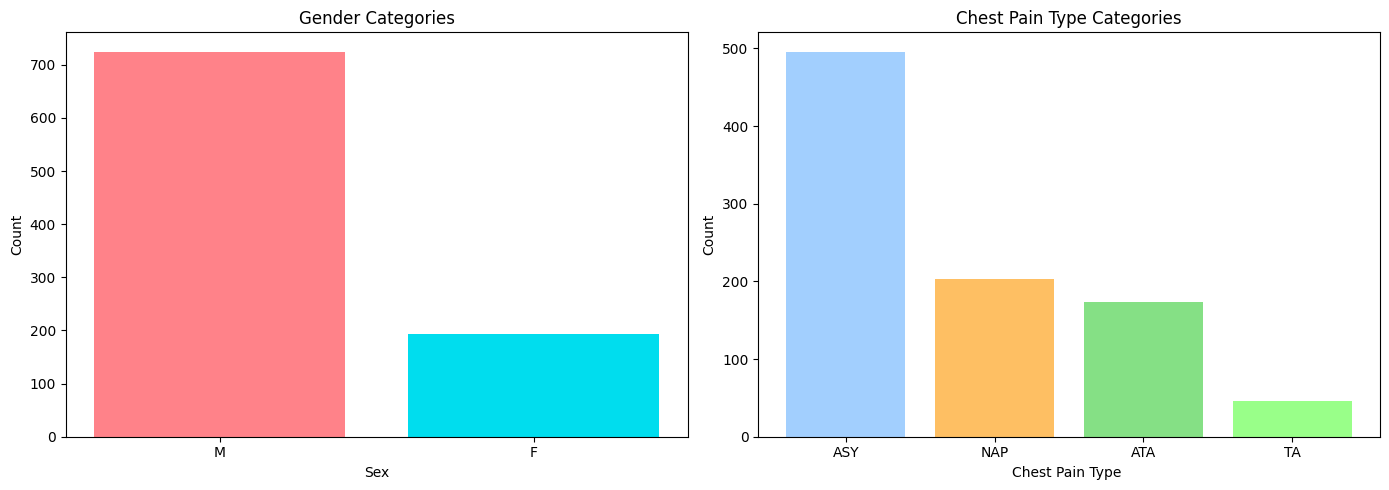

In [ ]:
# Filter separator rows
plot_data =  value_counts_df[value_counts_df.Category != "---"]

# Define colors
colors = {'M': '#FF8289', 'F': '#00ddee', 'ASY': '#a2cffe', 'NAP': '#febf63', 'ATA': '#85e085', 'TA':'#99ff89',
          'Normal':'#1d3557', 'LVH': '#A8DADC', 'ST':'#aec3b0', 'N':'#005B44', 'Y':'#FF8066', 'Flat':'#4FFBDF', 'Up': '#FBEAFF','Down':'#C4FCEF'}

# Set bar width
bar_width = 0.4

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Sex data
gender_data = plot_data.loc['Sex']
axes[0].bar(gender_data['Category'], gender_data['Count'], color=[colors[cat] for cat in gender_data['Category']], width=bar_width*2)
axes[0].set_title('Gender Categories')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Sex')

# Plot 'ChestPainType' data
geography_data = plot_data.loc['ChestPainType']
axes[1].bar(geography_data['Category'], geography_data['Count'], color=[colors[cat] for cat in geography_data['Category']], width=bar_width*2)
axes[1].set_title('Chest Pain Type Categories')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Chest Pain Type ')

# Adjust layout
plt.tight_layout()

# Display plots
plt.show()


Exercise Angina and ST Slope Graphical Distribution

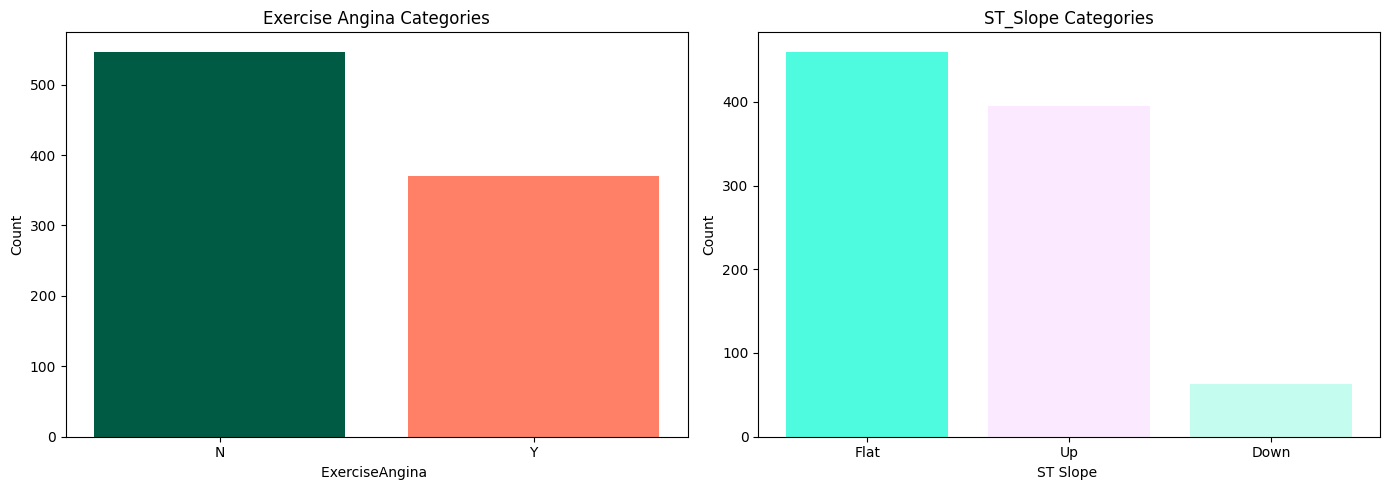

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))

ExerciseAngina_data = plot_data.loc['ExerciseAngina']
axis[0].bar(ExerciseAngina_data['Category'], ExerciseAngina_data['Count'], color=[colors[cat] for cat in ExerciseAngina_data['Category']], width=bar_width*2)
axis[0].set_title('Exercise Angina Categories')
axis[0].set_ylabel('Count')
axis[0].set_xlabel('ExerciseAngina ')

ST_Slope_data = plot_data.loc['ST_Slope']
axis[1].bar(ST_Slope_data['Category'], ST_Slope_data['Count'], color=[colors[cat] for cat in ST_Slope_data['Category']], width=bar_width*2)
axis[1].set_title('ST_Slope Categories')
axis[1].set_ylabel('Count')
axis[1].set_xlabel('ST Slope ')

# Adjust layout
plt.tight_layout()

# Display plots
plt.show()

Resting ECG Graphical Distribution

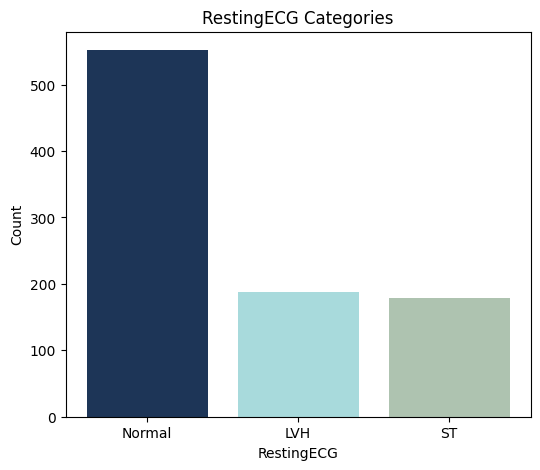

In [ ]:
fig, axes = plt.subplots(figsize=(6, 5))
RestingECG_data = plot_data.loc['RestingECG']
axes.bar(RestingECG_data['Category'], RestingECG_data['Count'], color=[colors[cat] for cat in RestingECG_data['Category']], width=bar_width*2)
axes.set_title('RestingECG Categories')
axes.set_ylabel('Count')
axes.set_xlabel('RestingECG')

plt.show()

**Label Encoding for Categorical labels**

Here we use a Label Encoder to deal with our categorical columns

In [ ]:
lab_Encoder = LabelEncoder()

X['Sex'] = lab_Encoder.fit_transform(X['Sex'])
X['ChestPainType'] = lab_Encoder.fit_transform(X['ChestPainType'])
X['RestingECG'] = lab_Encoder.fit_transform(X['RestingECG'])
X['ExerciseAngina'] = lab_Encoder.fit_transform(X['ExerciseAngina'])
X['ST_Slope'] = lab_Encoder.fit_transform(X['ST_Slope'])

X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [ ]:
heart_df = X['HeartDisease'].value_counts()
pd.DataFrame(heart_df)

,count
HeartDisease,
1,508
0,410


Visualising the target variable

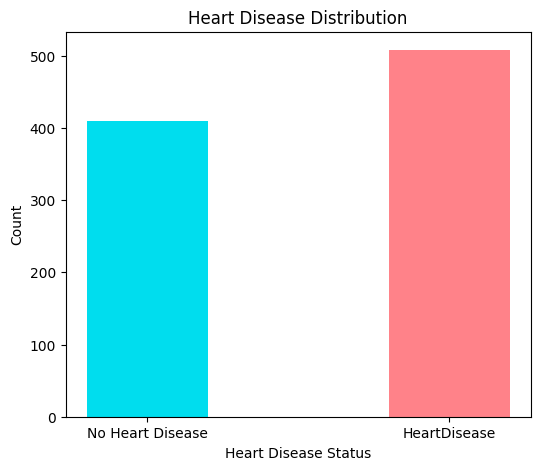

In [ ]:
target_series = pd.Series(heart_df)

colors = {0: '#00ddee', 1: '#FF8289'}

bar_width = 0.4

# create plot
fig, ax = plt.subplots(figsize=(6, 5))

ax.bar(target_series.index, target_series.values, width=bar_width, color= [colors[y] for y in target_series.index])

#Set title and labels
ax.set_title('Heart Disease Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Heart Disease Status')
ax.set_xticks(target_series.index)
ax.set_xticklabels(['HeartDisease', 'No Heart Disease'])
plt.show()

Visualizing Numerical Variables

In [ ]:
from scipy.stats import probplot, norm


# Define function for plotting histogram and plot for each numerical columns
def histogram_plot(dataframe, numerical_cols, cyan_palette=['#9468f8']):
    # loop through for each column
    for i, col in enumerate(numerical_cols):
        # Set figure size
        plt.figure(figsize=(15, len(numerical_cols)*5))
        # code for creating plot for the current column
        ax1 = plt.subplot(len(numerical_cols), 2, 2 * i + 1) # Changed to 2*i + 1 for QQ plot first
        probplot(dataframe[col], plot=ax1)
        ax1.get_lines()[0].set_color('#9468F8')
        ax1.get_lines()[1].set_color('#0000ff')
        plt.title(f'Probability plot of {col}')
        ax1.set_facecolor('#ffffff')

        # Create histogram for the current column
        ax2 = plt.subplot(len(numerical_cols), 2, 2 * i + 2) # Changed to 2*i + 2 for histogram second
        sns.histplot(dataframe[col], kde=True, bins=30, color='blue')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Display the plots
        plt.show()

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')


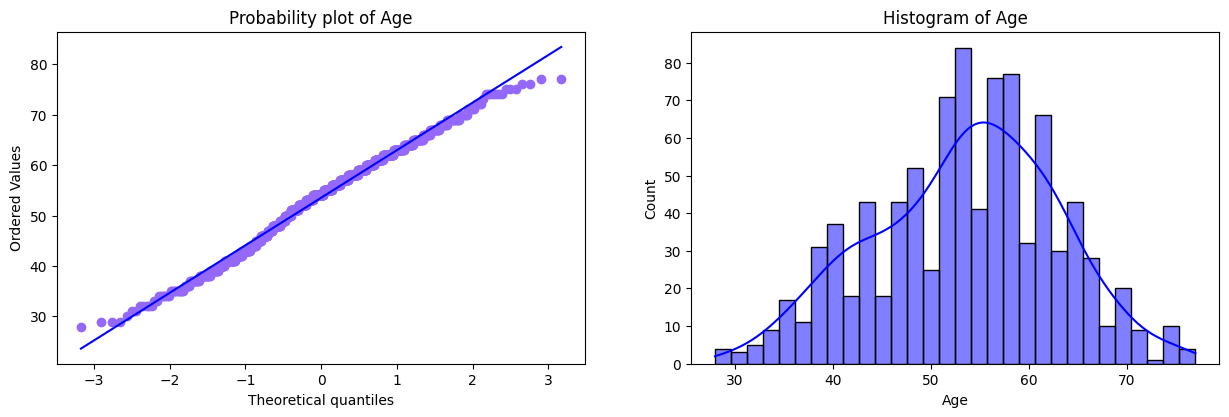

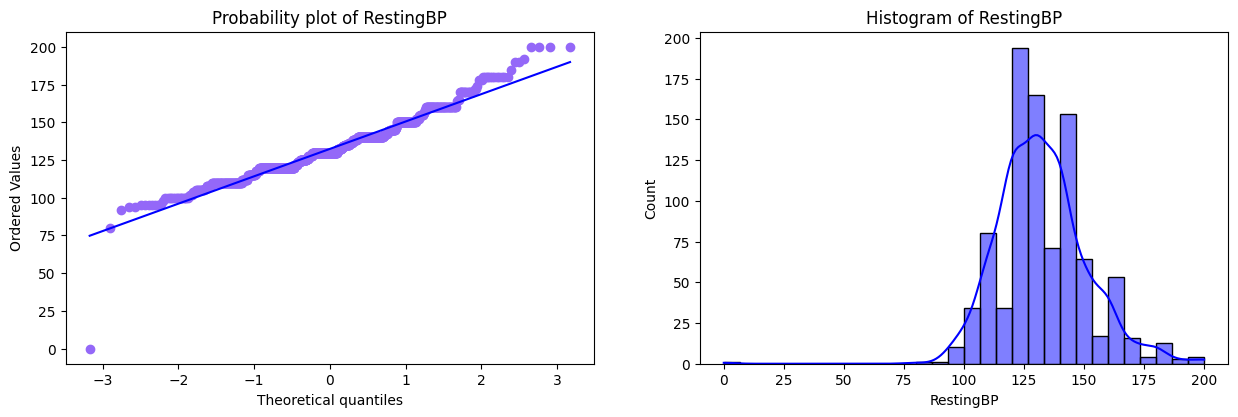

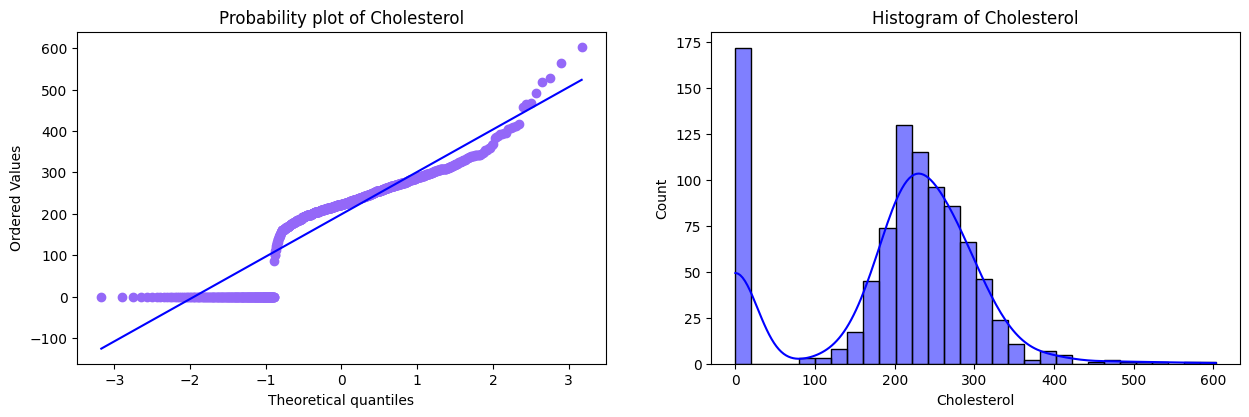

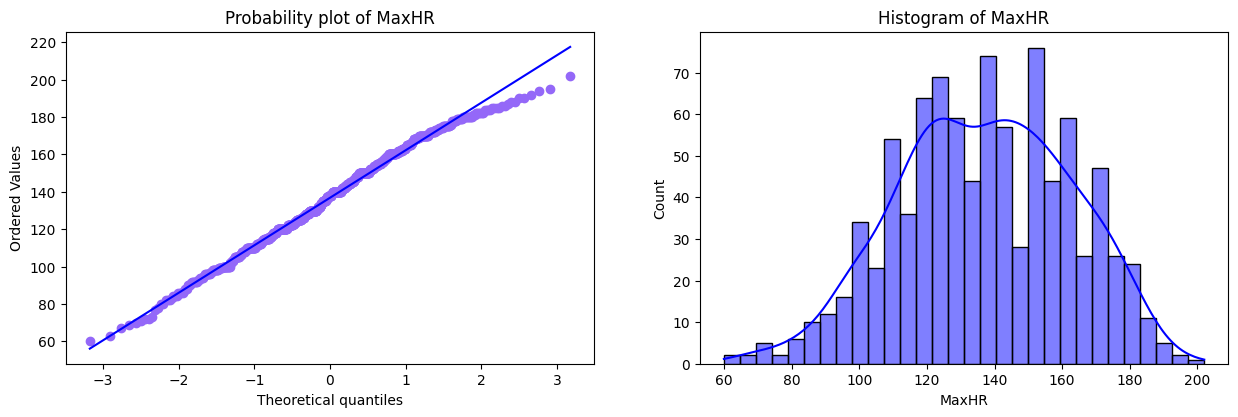

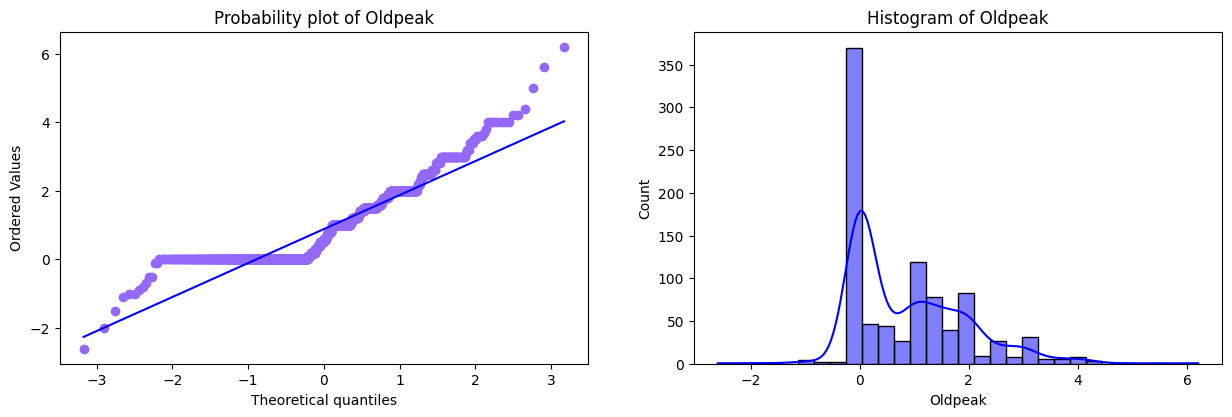

In [ ]:
new_df = data
num_cols_plot = new_df.select_dtypes(include=['float64', 'int64']).columns
print(num_cols_plot)

# Define columns to be dropped
columns_to_drop = [ 'FastingBS','HeartDisease']

# Drop specified columns from the list of numerical columns
num_cols_plot = num_cols_plot.drop(columns_to_drop)

# Call the function to plot histograms and QQ plots for the remaining numerical columns
histogram_plot(new_df, num_cols_plot)

**Describing the dataset**




In [ ]:
X.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,0.781046,132.396514,198.799564,0.233115,0.989107,136.809368,0.404139,0.887364,1.361656,0.553377
std,9.432617,0.407701,0.956519,18.514154,109.384145,0.423046,0.631671,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,173.250000,0.000000,1.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,1.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


Datascaling of the Dataset

In [ ]:
my_scaler = StandardScaler()
this_scaler = MinMaxScaler()

# Standardization
X['Age'] = my_scaler.fit_transform(X[['Age']])
X['RestingBP'] = my_scaler.fit_transform(X[['RestingBP']])
X['Cholesterol'] = my_scaler.fit_transform(X[['Cholesterol']])
X['MaxHR'] = my_scaler.fit_transform(X[['MaxHR']])

# Normalization
X['Oldpeak'] = this_scaler.fit_transform(X[['Oldpeak']])

X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.295455,2,0


DataFrame Description after Standardization

In [ ]:
X.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,9.180000e+02,918.000000,918.000000,9.180000e+02,918.000000,918.000000,918.000000,9.180000e+02,918.000000,918.000000,918.000000,918.000000
mean,-1.083616e-16,0.789760,0.781046,1.954380e-16,0.000000,0.233115,0.989107,4.953675e-16,0.404139,0.396291,1.361656,0.553377
std,1.000545e+00,0.407701,0.956519,1.000545e+00,1.000545,0.423046,0.631671,1.000545e+00,0.490992,0.121201,0.607056,0.497414
min,-2.706015e+00,0.000000,0.000000,-7.154995e+00,-1.818435,0.000000,0.000000,-3.018469e+00,0.000000,0.000000,0.000000,0.000000
25%,-6.906294e-01,1.000000,0.000000,-6.699346e-01,-0.233704,0.000000,1.000000,-6.605778e-01,0.000000,0.295455,1.000000,0.000000
50%,5.188098e-02,1.000000,0.000000,-1.295128e-01,0.221363,0.000000,1.000000,4.678968e-02,0.000000,0.363636,1.000000,1.000000
75%,6.883185e-01,1.000000,2.000000,4.109089e-01,0.623835,0.000000,1.000000,7.541571e-01,1.000000,0.465909,2.000000,1.000000
max,2.491558e+00,1.000000,3.000000,3.653439e+00,3.697252,1.000000,2.000000,2.561874e+00,1.000000,1.000000,2.000000,1.000000


Creating a HeatMap to find corresponding correlations

<Axes: >

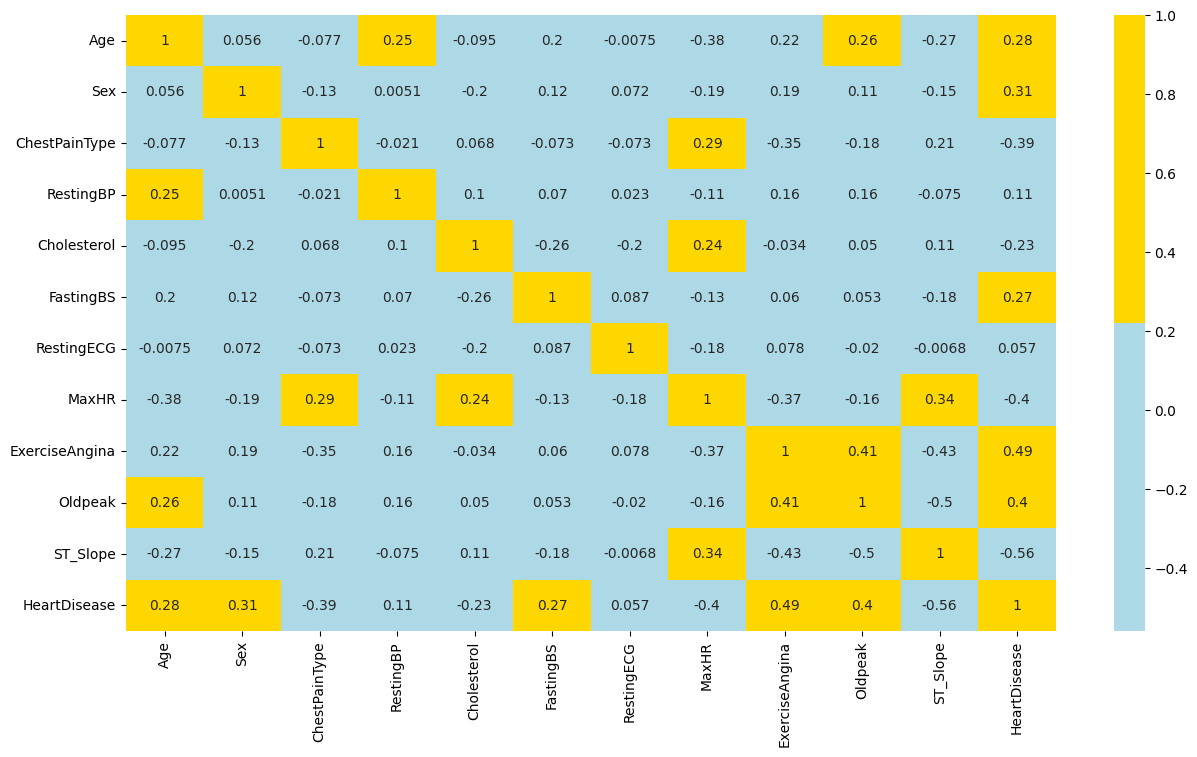

In [ ]:
colors = ['lightblue', 'gold']
plt.figure(figsize=(15,8))
sns.heatmap(X.corr(), annot = True, cmap=colors)

**Dropping Irrelevant features**

According to the Correlations with Heart Disease, Resting ECG and RestingBP had the lowest values.

Also drop main target feature HeartDisease


In [ ]:
X = X.drop(['RestingBP', 'RestingECG', 'HeartDisease'],axis = 1)
X

,Age,Sex,ChestPainType,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,-1.433140,1,1,0.825070,0,1.382928,0,0.295455,2
1,-0.478484,0,2,-0.171961,0,0.754157,0,0.409091,1
2,-1.751359,1,1,0.770188,0,-1.525138,0,0.295455,2
3,-0.584556,0,0,0.139040,0,-1.132156,1,0.465909,1
4,0.051881,1,2,-0.034755,0,-0.581981,0,0.295455,2
...,...,...,...,...,...,...,...,...,...
913,-0.902775,1,3,0.596393,0,-0.188999,0,0.431818,1
914,1.536902,1,0,-0.053049,1,0.164684,0,0.681818,1
915,0.370100,1,0,-0.620168,0,-0.857069,1,0.431818,1
916,0.370100,0,1,0.340275,0,1.461525,0,0.295455,1


Saving the Dataframe into a numpy array

In [ ]:
X = X.values
y = y.values
X

array([[-1.4331398 ,  1.        ,  1.        , ...,  0.        ,
         0.29545455,  2.        ],
       [-0.47848359,  0.        ,  2.        , ...,  0.        ,
         0.40909091,  1.        ],
       [-1.75135854,  1.        ,  1.        , ...,  0.        ,
         0.29545455,  2.        ],
       ...,
       [ 0.37009972,  1.        ,  0.        , ...,  1.        ,
         0.43181818,  1.        ],
       [ 0.37009972,  0.        ,  1.        , ...,  0.        ,
         0.29545455,  1.        ],
       [-1.64528563,  1.        ,  2.        , ...,  0.        ,
         0.29545455,  2.        ]])

Partition using the data using the train_test_split method

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify = y,
                                                  random_state=0)

Implementing the Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

def bagging_model(model_name):
    clf = BaggingClassifier(estimator= model_name,
                            n_estimators= 100,
                            oob_score= True,
                            max_samples = 0.8,
                            random_state=0)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_val)
    Model_Accuracy = accuracy_score(y_val, prediction)

    this_matrix = confusion_matrix(y_val, prediction)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in this_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1 ,v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5,3))
    sns.heatmap(this_matrix, annot=labels, fmt='', cmap='Blues')
    print(classification_report(y_val, prediction))
    print(confusion_matrix(y_val, prediction))
    print('F1_score ',f1_score(y_val, prediction))

    cv_scores = cross_val_score(clf, X_train, y_train, cv=6)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {np.mean(cv_scores):.2f}")
    print(f"Standard Deviation of CV accuracy: {np.std(cv_scores):.2f}")

    return round(Model_Accuracy*100)

Evaluating the Bagging Classifier Individuals using Various Max Estimators Variables

In [ ]:
SupportVector_model = SVC(kernel = 'linear', C = 0.5)
Xgboost_model = XGBClassifier(n_estimators = 1000, max_depth = 4,
                          learning_rate = 0.005, n_jobs = 4)
Decision_model = DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 1,random_state =42)
Random_model = RandomForestClassifier(max_depth=5)

estimators = [0.6, 0.7, 0.8, 0.9, 1.0]
models = [SupportVector_model, Decision_model, Random_model,Xgboost_model]
results = {}

for j in models:
  print(j)
  scores = list()
  for n in estimators:
    clf = BaggingClassifier(estimator= j,
                                n_estimators= 100,
                                oob_score= True,
                                max_samples = n,
                                )
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_val)
    Model_Accuracy = accuracy_score(y_val, prediction)
    Model_Accuracy = round(Model_Accuracy*100)
    scores.append(Model_Accuracy)
  results[j.__class__.__name__] = scores
  cv = StratifiedKFold(n_splits = 5)
  cv_scores = cross_val_score(clf, X_train, y_train, cv=cv)
  print(f"Cross-validation scores: {cv_scores}")
  print(f"Mean CV accuracy: {mean(cv_scores):.4f}")
  print(f"Standard Deviation of CV accuracy: {std(cv_scores):.4f}")

print(results)

SVC(C=0.5, kernel='linear')
Cross-validation scores: [0.85034014 0.78911565 0.85714286 0.81632653 0.9109589 ]
Mean CV accuracy: 0.8448
Standard Deviation of CV accuracy: 0.0412
DecisionTreeClassifier(max_depth=4, random_state=42)
Cross-validation scores: [0.9047619  0.82312925 0.85034014 0.84353741 0.88356164]
Mean CV accuracy: 0.8611
Standard Deviation of CV accuracy: 0.0292
RandomForestClassifier(max_depth=5)
Cross-validation scores: [0.9047619  0.82993197 0.84353741 0.85714286 0.89041096]
Mean CV accuracy: 0.8652
Standard Deviation of CV accuracy: 0.0282
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
             

[Text(1, 0, 'SVC'),
 Text(2, 0, 'DecisionTreeClassifier'),
 Text(3, 0, 'RandomForestClassifier'),
 Text(4, 0, 'XGBClassifier')]

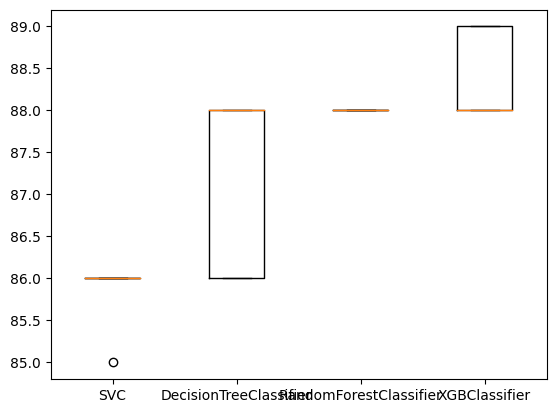

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

XGB Classifier
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        82
           1       0.91      0.87      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

[[73  9]
 [13 89]]
F1_score  0.89
Cross-validation scores: [0.92682927 0.83739837 0.83606557 0.87704918 0.81967213 0.90163934]
Mean CV accuracy: 0.87
Standard Deviation of CV accuracy: 0.04
88


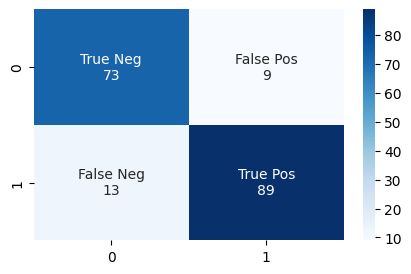

In [ ]:
print('XGB Classifier')
l3_model = XGBClassifier(n_estimators = 1000, max_depth = 4,
                          learning_rate = 0.005, n_jobs = 4)
Bag_XGB = bagging_model(l3_model)
print(Bag_XGB)


SVC classifier
              precision    recall  f1-score   support

           0       0.81      0.90      0.86        82
           1       0.91      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184

[[74  8]
 [17 85]]
F1_score  0.8717948717948718
Cross-validation scores: [0.84552846 0.80487805 0.85245902 0.86065574 0.79508197 0.92622951]
Mean CV accuracy: 0.85
Standard Deviation of CV accuracy: 0.04
86
------------------------------------------


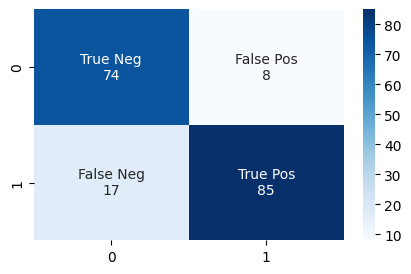

In [ ]:
print('SVC classifier')
l4_model = SVC(kernel = 'linear', C = 0.5)
Bag_SVC = bagging_model(l4_model)
print(Bag_SVC)
print('------------------------------------------')

Decision Tree
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        82
           1       0.91      0.86      0.88       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184

[[73  9]
 [14 88]]
F1_score  0.8844221105527639
Cross-validation scores: [0.90243902 0.81300813 0.82786885 0.87704918 0.80327869 0.87704918]
Mean CV accuracy: 0.85
Standard Deviation of CV accuracy: 0.04
88
------------------------------------------


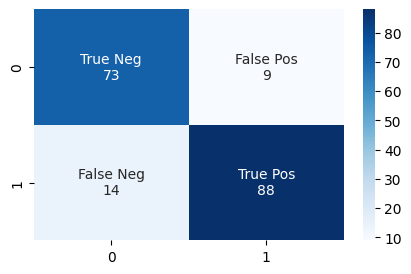

In [ ]:
print('Decision Tree')
l5_model = DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 1,random_state =42)
Bag_Decision = bagging_model(l5_model)
print(Bag_Decision)
print('------------------------------------------')

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        82
           1       0.91      0.88      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184

[[73  9]
 [12 90]]
F1_score  0.8955223880597014
Cross-validation scores: [0.91056911 0.81300813 0.85245902 0.8852459  0.82786885 0.89344262]
Mean CV accuracy: 0.86
Standard Deviation of CV accuracy: 0.04
89
------------------------------------------


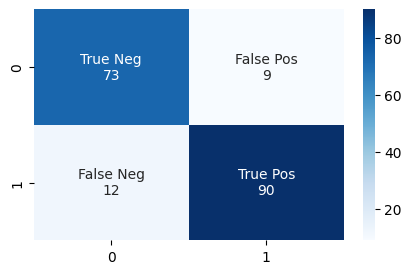

In [ ]:
print('Random Forest Classifier')
l1_model = RandomForestClassifier(max_depth=5)
Bag_Random = bagging_model(l1_model)
print(Bag_Random)
print('------------------------------------------')

Individual Models without Bagging

In [ ]:
def Without_Bagging_model(Classifier):

    Classifier.fit(X_train, y_train)
    prediction = Classifier.predict(X_val)
    this_matrix = confusion_matrix(y_val, prediction)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in this_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1 ,v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5,3))
    sns.heatmap(this_matrix, annot=labels, fmt='', cmap='Blues')
    print(classification_report(y_val, prediction))
    print('Model Accuracy',accuracy_score(y_val, prediction))
    print('F1_score ',f1_score(y_val, prediction))
    ans = Classifier.score(X_val, y_val)
    return ans


Random Forest Classifier
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        82
           1       0.90      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Model Accuracy 0.8586956521739131
F1_score  0.8673469387755102
0.8586956521739131
------------------------------------------


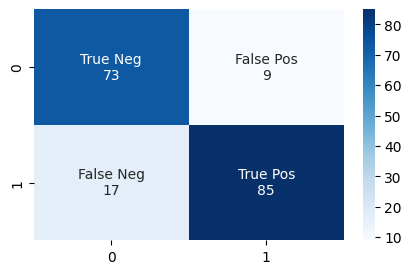

In [ ]:
print('Random Forest Classifier')
RFC_model = RandomForestClassifier(max_depth=5)
Notbagged_Random = Without_Bagging_model(RFC_model)
print(Notbagged_Random)
print('------------------------------------------')

XGB Classifier
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Model Accuracy 0.8804347826086957
F1_score  0.8921568627450981
0.8804347826086957
------------------------------------------


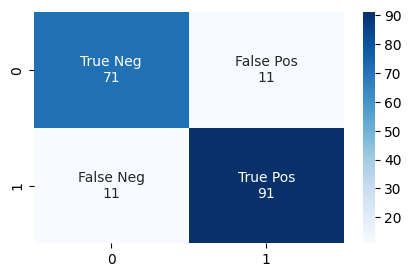

In [ ]:
print('XGB Classifier')
XGB_model = XGBClassifier(n_estimators = 1000, max_depth = 4,
                          learning_rate = 0.005, n_jobs = 4)
NotBagged_XGB = Without_Bagging_model(XGB_model)
print(NotBagged_XGB)
print('------------------------------------------')

SVC classifier
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        82
           1       0.90      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Model Accuracy 0.8586956521739131
F1_score  0.8673469387755102
0.8586956521739131
------------------------------------------


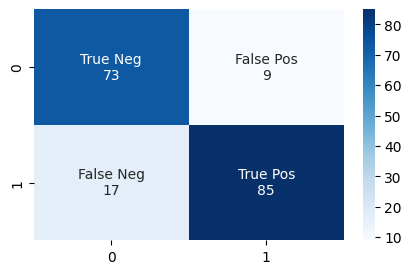

In [ ]:
print('SVC classifier')
SVC_model = SVC(kernel = 'linear', C = 0.5,  probability=True)
NotBagged_SVC = Without_Bagging_model(SVC_model)
print(NotBagged_SVC)
print('------------------------------------------')

Decision Tree
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        82
           1       0.88      0.84      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Model Accuracy 0.8478260869565217
F1_score  0.86
0.8478260869565217
------------------------------------------


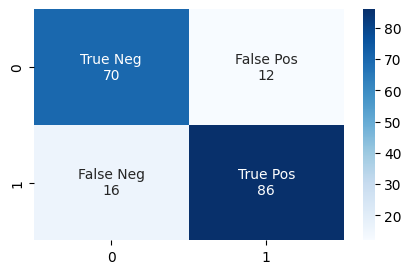

In [ ]:
print('Decision Tree')
DecisionTree_model = DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 1,random_state =42)
NotBagged_DecisionTree = Without_Bagging_model(DecisionTree_model)
print(NotBagged_DecisionTree)
print('------------------------------------------')

**Final Ensemble**

In [ ]:
voting_reg = VotingClassifier(estimators=[('M1',BaggingClassifier(estimator= RandomForestClassifier(max_depth=5), n_estimators= 100,
                                                                   oob_score= True,  max_samples = 0.8, random_state=0)),
                                          ('M2',BaggingClassifier(estimator= XGBClassifier(n_estimators = 1000, max_depth = 4, learning_rate = 0.005, n_jobs = 4),
                                                                  n_estimators= 100, oob_score= True, max_samples = 0.8, random_state=0)),
                                          ('M3',BaggingClassifier(estimator= SVC(kernel = 'linear', C = 0.5), n_estimators= 100, oob_score= True,
                                                                   max_samples = 0.8, random_state=0)),
                                          ('M4',BaggingClassifier(estimator= DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 1,random_state =42),
                                                                  n_estimators= 100, oob_score= True, max_samples = 0.8, random_state=0))],
                                          voting = 'soft' ,
                                         weights=[2,4,1,1])

voting_reg.fit(X_train, y_train)
vote_pred = voting_reg.predict(X_val)
score = accuracy_score(y_val, vote_pred)
print('Voting score', score)
print('Model score ACCURACY', voting_reg.score(X_val, y_val))
print(confusion_matrix(y_val, vote_pred))
print(classification_report(y_val, vote_pred))
print('F1_score ',f1_score(y_val, vote_pred))

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and collect the results
cross_val_results = cross_val_score(voting_reg, X_train, y_train, cv=kf, scoring='accuracy')

# Calculate the standard deviation between folds
std_deviation_between_folds = np.std(cross_val_results)
print(f"Cross-Validation Results: {cross_val_results}")
print(f"Standard Deviation between Folds: {std_deviation_between_folds:.4f}")

Voting score 0.8913043478260869
Model score ACCURACY 0.8913043478260869
[[74  8]
 [12 90]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        82
           1       0.92      0.88      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

F1_score  0.9
Cross-Validation Results: [0.88435374 0.86394558 0.8707483  0.86394558 0.82876712]
Standard Deviation between Folds: 0.0184


Evaluating the Bagging Classifier Ensemble using Various Max Estimators Variables

In [ ]:
Xgboost_model = XGBClassifier(n_estimators = 1000, max_depth = 4,
                          learning_rate = 0.005, n_jobs = 4, random_state=42)
Decision_model = DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 1,random_state =42)
Random_model = RandomForestClassifier(max_depth=5, random_state =42)
SVC_model = SVC(kernel = 'linear', C = 0.5, random_state =42)

max_estimators = [0.6, 0.7, 0.8, 0.9, 1.0]

base_estimators = [('M1', BaggingClassifier(base_estimator= Random_model, n_estimators= 100, oob_score= True)),
                    ('M2',BaggingClassifier(base_estimator= Xgboost_model, n_estimators= 100, oob_score= True)),
                    ('M3',BaggingClassifier(base_estimator= SVC_model, n_estimators= 100, oob_score= True)),
                   ('M4',BaggingClassifier(base_estimator=Decision_model,  n_estimators= 100, oob_score= True))]

max_bag_sample = VotingClassifier(estimators = base_estimators, voting = 'soft', weights = [2,4,1,1])
results = {}
accuracies = list()

for max_samples_value in max_estimators:

  updated_estimators = [
      (name, BaggingClassifier(base_estimator = estimator.base_estimator, max_samples=max_samples_value))
      for name, estimator in base_estimators
  ]

  max_bag_sample.estimators = updated_estimators

    # Fit the voting classifier on the training data
  max_bag_sample.fit(X_train, y_train)

    # Make predictions on the test data
  y_pred = max_bag_sample.predict(X_val)

    # Calculate accuracy and store the result
  accuracy = accuracy_score(y_val, y_pred)
  results[max_samples_value] = accuracy
  accuracies.append(accuracy)

# Print the results
for max_samples_value, accuracy in results.items():
  print(f"Max Samples: {max_samples_value}, Accuracy: {accuracy:.4f}")

print(f"Mean CV accuracy: {mean(accuracies):.4f}")
print(f"Standard Deviation of CV accuracy: {std(accuracies):.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Max Samples: 0.6, Accuracy: 0.8750
Max Samples: 0.7, Accuracy: 0.8913
Max Samples: 0.8, Accuracy: 0.8804
Max Samples: 0.9, Accuracy: 0.8859
Max Samples: 1.0, Accuracy: 0.8804
Mean CV accuracy: 0.8826
Standard Deviation of CV accuracy: 0.0055


Bagged Ensemble ROC plot

Voting Prediction 0.9528933524629364


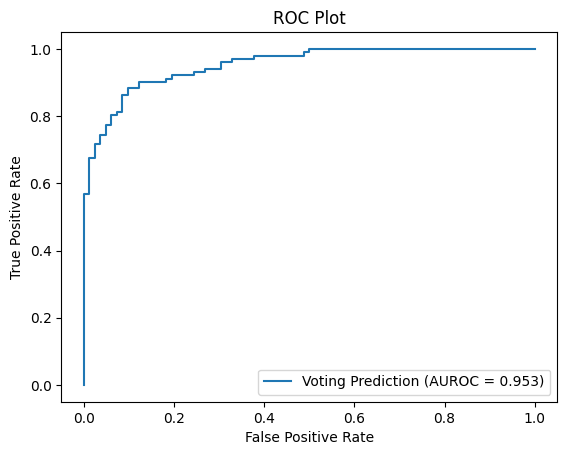

In [ ]:
vote_probs = voting_reg.predict_proba(X_val)
vote_probs = vote_probs[:,1]
vote_auc = roc_auc_score(y_val, vote_probs)
r_fpr, r_tpr,_ = roc_curve(y_val, vote_probs)
print('Voting Prediction', vote_auc)

plt.plot(r_fpr, r_tpr, linestyle='-', label='Voting Prediction (AUROC = %0.3f)' % vote_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
RFC_model = RandomForestClassifier(max_depth=5)

XGBC_model = XGBClassifier(n_estimators = 1000, max_depth = 4,
                          learning_rate = 0.005, n_jobs = 4)

SVC_model = SVC(kernel = 'linear', C = 0.5, probability=True)

DTC_model = DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 1,random_state =42)

Comparing Un-Bagged Individual Classifiers with the Final Bagged Ensemble

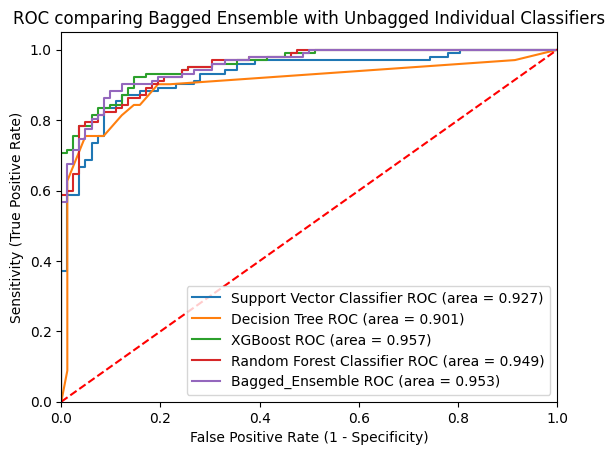

In [ ]:
plt.figure()

models = [
{
    'label': 'Support Vector Classifier',
    'model': SVC_model
},
{
    'label': 'Decision Tree',
    'model': DTC_model
},
 {
     'label': 'XGBoost',
     'model': XGBC_model

},
{
    'label': 'Random Forest Classifier',
    'model': RFC_model
},
{
    'label': 'Bagged_Ensemble',
    'model': voting_reg
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']
    model.fit(X_train, y_train) # train the model
    y_pred = model.predict(X_val) # predict the test data
    new_pred =  model.predict_proba(X_val)[:,1]

# Compute False postive rate, and True positive rate
    fpr, tpr, _ = roc_curve(y_val, new_pred)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_val, new_pred)
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC comparing Bagged Ensemble with Unbagged Individual Classifiers')
plt.legend(loc="lower right")
plt.show()   # Display

Comparing Bagged Classifiers with the Final Bagged Ensemble

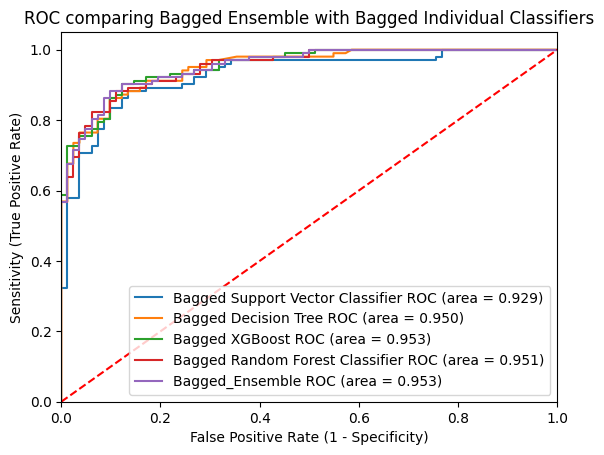

In [ ]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Bagged Support Vector Classifier',
    'model':  BaggingClassifier(estimator= SVC_model,n_estimators= 100,
                  oob_score= True, max_samples = 0.8,random_state=0),
},
{
    'label': 'Bagged Decision Tree',
    'model':   BaggingClassifier(estimator= DTC_model,n_estimators= 100,
                  oob_score= True, max_samples = 0.8,random_state=0),
},
 {
     'label': 'Bagged XGBoost',
     'model':  BaggingClassifier(estimator= XGBC_model,n_estimators= 100,
                  oob_score= True, max_samples = 0.8,random_state=0)

},
{
    'label': 'Bagged Random Forest Classifier',
    'model':  BaggingClassifier(estimator= RFC_model,n_estimators= 100,
                  oob_score= True, max_samples = 0.8,random_state=0)

},
{
    'label': 'Bagged_Ensemble',
    'model': voting_reg
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model']
    model.fit(X_train, y_train) # train the model
    y_pred = model.predict(X_val) # predict the test data
    new_pred =  model.predict_proba(X_val)[:,1]

# Compute False postive rate, and True positive rate
    fpr, tpr, _ = roc_curve(y_val, new_pred)
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_val, new_pred)
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC comparing Bagged Ensemble with Bagged Individual Classifiers')
plt.legend(loc="lower right")
plt.show()   # Display

In [ ]:
testing_pd = pd.DataFrame({'Age':'40', 'Sex':0, 'ChestPainType':0, 'Cholesterol':'289','FastingBS':0, 'MaxHR':172, 'ExerciseAngina':'1', 'Oldpeak':'0.0', 'ST_Slope':'2'} ,index=[0])
print(testing_pd)
new_pred = voting_reg.predict(testing_pd)
new_pred

  Age  Sex  ChestPainType Cholesterol  FastingBS  MaxHR ExerciseAngina  \
0  40    0              0         289          0    172              1   

  Oldpeak ST_Slope  
0     0.0        2  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


array([0])

<Axes: >

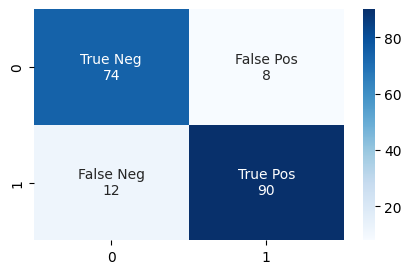

In [ ]:
clf_matrix = confusion_matrix(y_val, vote_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in clf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1 ,v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(5,3))
sns.heatmap(clf_matrix, annot=labels, fmt='', cmap='Blues')

Saving the Ensemble model as Pickle

In [ ]:
# Saving the desired model
with open('/content/drive/MyDrive/Colab Notebooks/HeartDisease_Prediction/Heart_disease/Heart_Disease.pkl', 'wb') as file:
  pickle.dump(voting_reg, file)

In [ ]:
# Opening the desired model
# with open('Heart_Disease.pkl', 'rb') as file:
#  pk_model =  pickle.load(file)

# pk_pred = pk_model.predict([[40, 0, 0, 289,0,172, 1,0.0,2]])
# print("The result is",pk_pred) # Printing result